In [19]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from copy import deepcopy
from itertools import product
from tqdm import tqdm

import utils as u
import optimizers as opt

In [20]:
def experimental_loop(n_steps, X_train, y_train, X_test, y_test, batch_size, init_model, l2_reg, optimizer):
    model_params = deepcopy(init_model)
    loss_history = {'train_loss': list(), 'test_loss': list()}
    for epoch in range(n_steps):
        random_idx = np.random.permutation(X_train.shape[0])
        X_train, y_train = tf.gather(X_train, random_idx), tf.gather(y_train, random_idx)
        n_batches = (X_train.shape[0] // batch_size) + 1

        for ii in range(n_batches):
            X_batch = X_train[ii*batch_size : (ii+1)*batch_size, :]
            y_batch = y_train[ii*batch_size : (ii+1)*batch_size]
            with tf.GradientTape() as tape:
                y_pred = u.logistic_function(X_batch, model_params)
                batch_loss = u.cross_entropy(y_batch, y_pred) + l2_reg*tf.reduce_sum(model_params**2)
            batch_gradients = tape.gradient(batch_loss, model_params)
            optimizer.apply_gradients(batch_gradients, model_params)

        loss_history['train_loss'].append(u.cross_entropy(y_train, u.logistic_function(X_train, model_params)))
        loss_history['test_loss'].append(u.cross_entropy(y_test, u.logistic_function(X_test, model_params)))

    #print(f'Epoch {epoch} loss: {cross_entropy(y_train, logistic_function(X_train, model_params))}')
    return loss_history, model_params

# Experiments

## SGD with cross validation


In [21]:
from matplotlib import pyplot as plt
from seaborn import heatmap
from utils import folding_tensor_from_sklearn


In [22]:
init_model = tf.Variable(tf.random.normal([31], 0, 0.1))


In [23]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)


In [24]:
n_fold = 5
X_folds, y_folds = folding_tensor_from_sklearn(X, y, n_fold)

In [25]:
learning_rates = np.logspace(-1, -7, num=20)
l2_rates = np.logspace(-1, -7, num=20)

In [26]:
#exp_log = list()
results = tf.Variable(tf.zeros((len(learning_rates), len(l2_rates), n_fold)))
n_steps = 500
batch_size = X.shape[0]
for fold, lr_id, l2_id in tqdm(product(range(n_fold), range(len(learning_rates)), range(len(l2_rates)))):
    sgd = opt.SGD(lr = learning_rates[lr_id])
    tmp_history = experimental_loop(n_steps, X_folds[fold][0], y_folds[fold][0], X_folds[fold][1], y_folds[fold][1], batch_size, init_model, l2_reg = l2_rates[l2_id], optimizer=sgd)[0]
    results[lr_id, l2_id, fold].assign(tmp_history['test_loss'][-1])
    #exp_log.append({'lr': config[0], 'l2': config[1], 'train_loss': tmp_history['train_loss'][-1].numpy(), 'test_loss': tmp_history['test_loss'][-1].numpy()})

2000it [1:32:34,  2.78s/it]


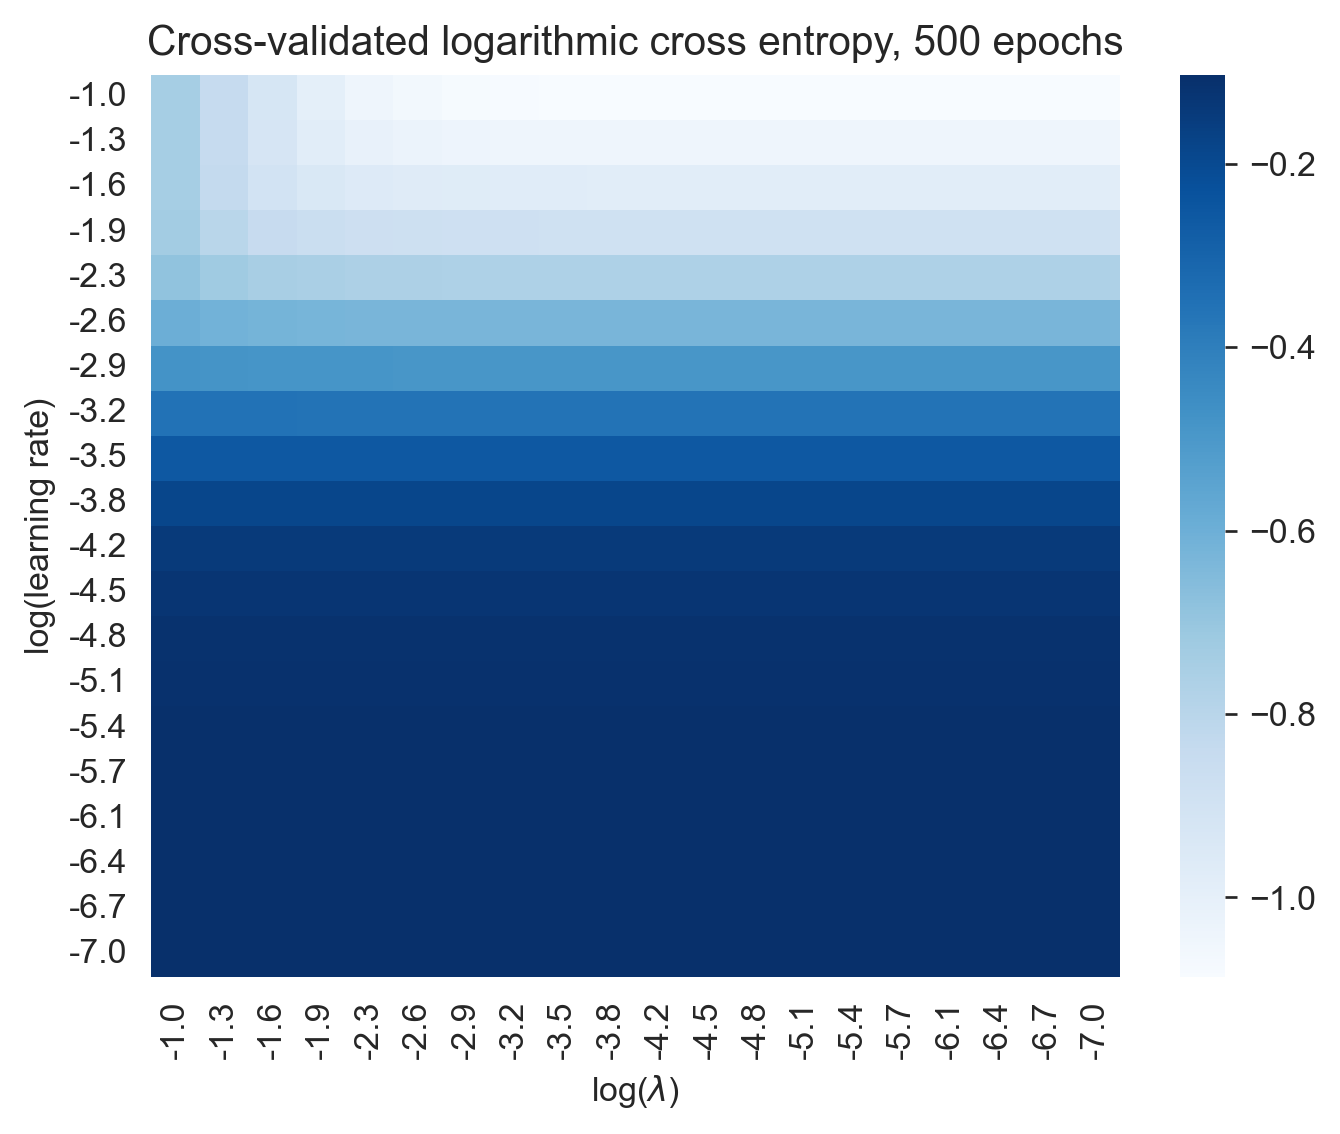

In [27]:
fig, ax = plt.subplots(dpi=244)
heatmap(np.log10(tf.reduce_mean(results, axis=2)), cmap=plt.cm.Blues, xticklabels=np.round(np.log10(learning_rates), 1), yticklabels=np.round(np.log10(l2_rates), 1))
ax.set(title='Cross-validated logarithmic cross entropy, 500 epochs', ylabel="log(learning rate)", xlabel=r"log($\lambda$)")
plt.savefig('results/part_g/gd_lr_vs_l2_500_epochs.png')

## Sklearn's logistic regression model

In [28]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score

In [29]:
#clf = LogisticRegression(random_state=2137)

In [30]:
sk_lr = 0.001
sk_l2 = 0.0001
clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=sk_l2, learning_rate='constant', eta0=sk_lr)

In [37]:
results = tf.Variable(tf.zeros((len(learning_rates), len(l2_rates), n_fold)))
for fold, lr_id, l2_id in tqdm(product(range(n_fold), range(len(learning_rates)), range(len(l2_rates)))):
    clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=l2_rates[l2_id], learning_rate='constant', eta0=learning_rates[lr_id], max_iter=n_steps)
    clf.fit(X_folds[fold][0], y_folds[fold][0])
    results[lr_id, l2_id, fold].assign(u.cross_entropy(y_folds[fold][1], clf.predict(X_folds[fold][1])))

2000it [00:07, 274.47it/s]


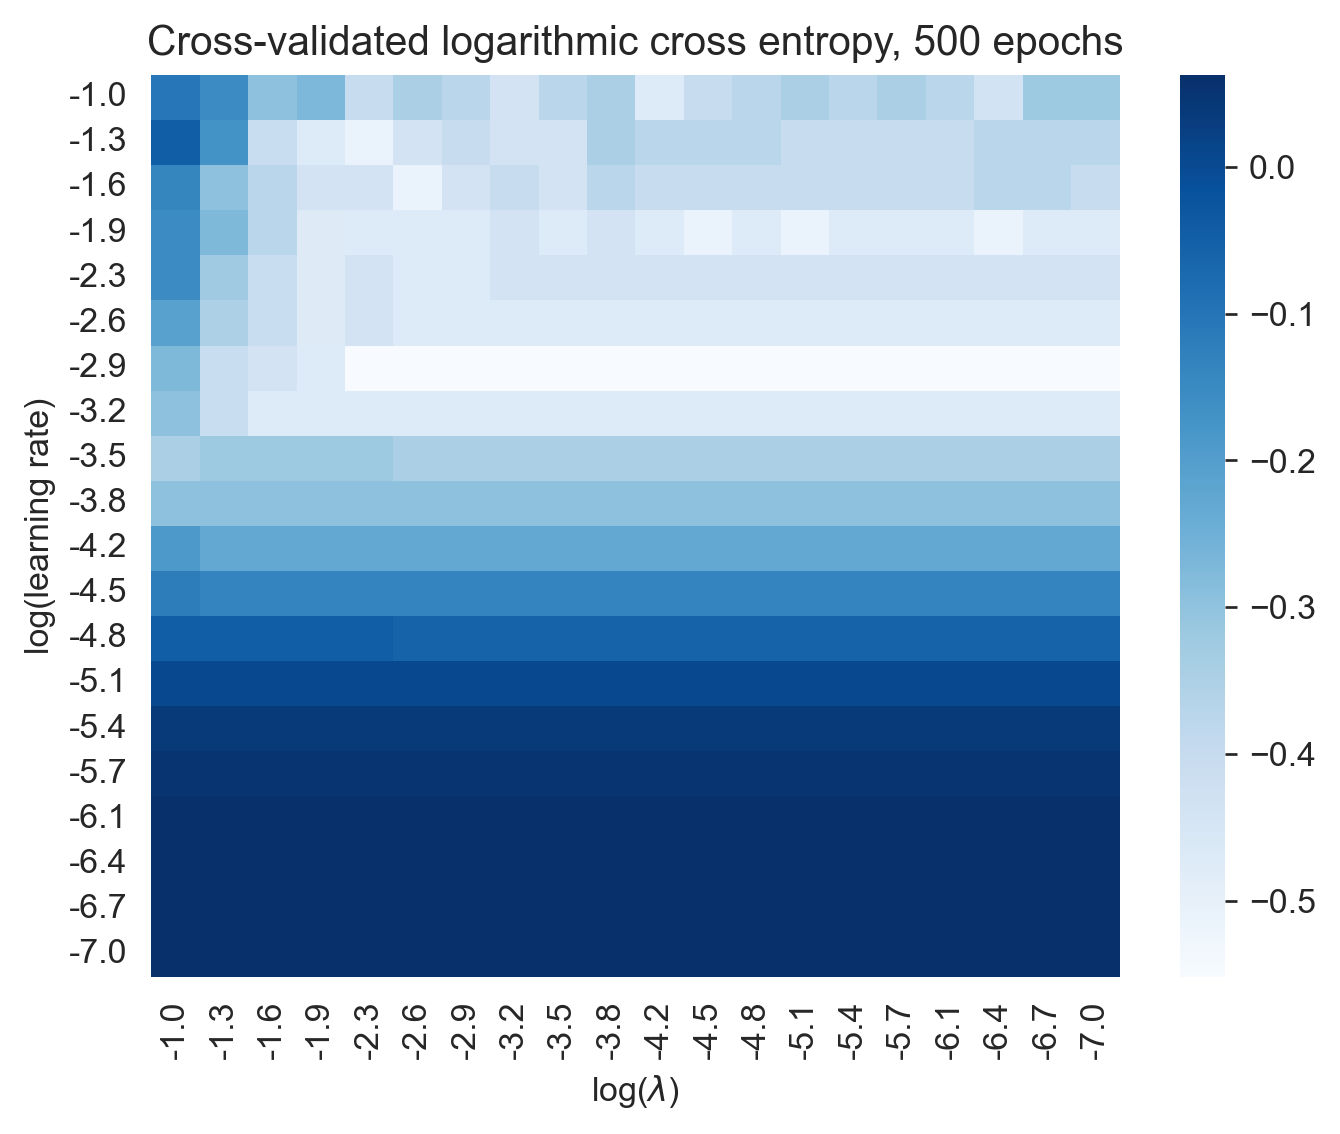

In [38]:

fig, ax = plt.subplots(dpi=244)
heatmap(np.log10(tf.reduce_mean(results, axis=2)), cmap=plt.cm.Blues, xticklabels=np.round(np.log10(learning_rates), 1), yticklabels=np.round(np.log10(l2_rates), 1))
ax.set(title='Cross-validated logarithmic cross entropy, 500 epochs', ylabel="log(learning rate)", xlabel=r"log($\lambda$)")
plt.savefig('results/part_g/sklearn_gd_lr_vs_l2_500_epochs.png')